<center><h1><b></b>Bank Customer Churn Prediction</h1></center>

<center>https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling</center>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras as ks
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

%matplotlib inline

In [3]:
df = pd.read_csv('/kaggle/input/bank-customer-churn-modeling/Churn_Modelling.csv')
df[:5]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.shape

(10000, 14)

In [5]:
df.isnull().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [6]:
df.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [7]:
df1 = df.drop(columns = ['RowNumber', 'CustomerId', 'Surname'], axis = 1)

In [8]:
df1[:2]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0


In [9]:
df1.shape

(10000, 11)

In [10]:
# tenure of customers that did not leave
tenure_exited_no = df1[df1['Exited'] == 0].Tenure
tenure_exited_no 

1        1
3        1
4        2
6        7
8        4
        ..
9993     7
9994     2
9995     5
9996    10
9999     4
Name: Tenure, Length: 7963, dtype: int64

In [11]:
# tenure of customers that left
tenure_exited_yes = df1[df1['Exited'] == 1].Tenure
tenure_exited_yes 

0       2
2       8
5       8
7       4
16      1
       ..
9981    3
9982    7
9991    4
9997    7
9998    3
Name: Tenure, Length: 2037, dtype: int64

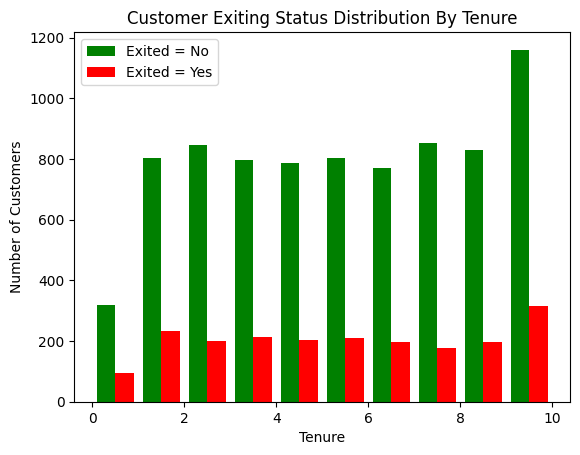

In [12]:
# Plotting the histogram of the tenure exit
plt.hist([tenure_exited_no, tenure_exited_yes], color = ['g', 'r'], label = ['Exited = No', 'Exited = Yes'])
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.title('Customer Exiting Status Distribution By Tenure')
plt.legend();

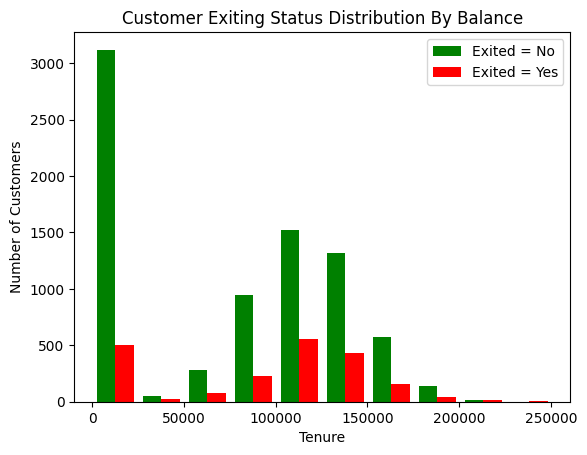

In [13]:
# Plotting the histogram of the balance exit
balance_exited_no = df1[df1['Exited'] == 0].Balance
balance_exited_yes = df1[df1['Exited'] == 1].Balance

plt.hist([balance_exited_no, balance_exited_yes], color = ['g', 'r'], label = ['Exited = No', 'Exited = Yes'])
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.title('Customer Exiting Status Distribution By Balance')
plt.legend();

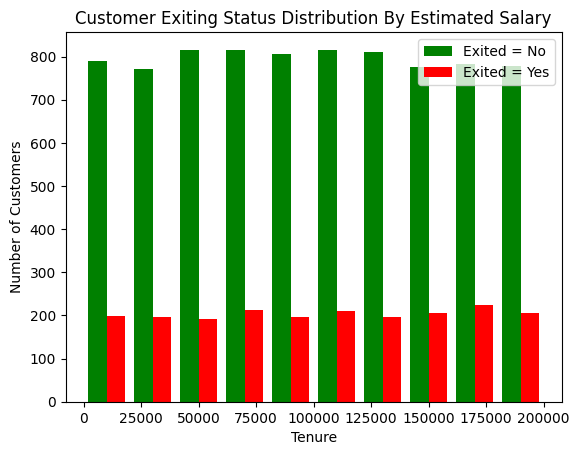

In [14]:
# Plotting the histogram of the salary exit
salary_exited_no = df1[df1['Exited'] == 0].EstimatedSalary
salary_exited_yes = df1[df1['Exited'] == 1].EstimatedSalary

plt.hist([salary_exited_no, salary_exited_yes], color = ['g', 'r'], label = ['Exited = No', 'Exited = Yes'])
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.title('Customer Exiting Status Distribution By Estimated Salary')
plt.legend();

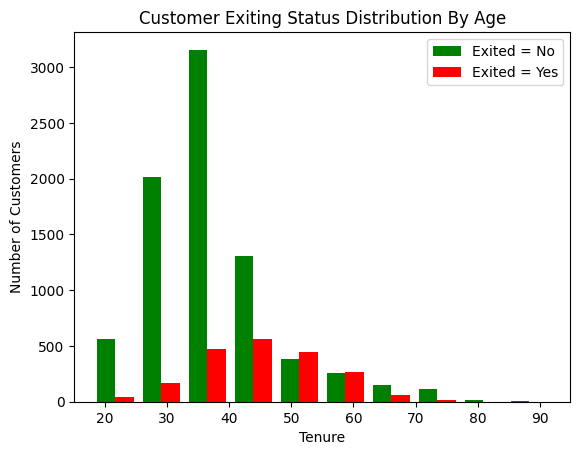

In [15]:
# Plotting the histogram of the salary exit
age_exited_no = df1[df1['Exited'] == 0].Age
age_exited_yes = df1[df1['Exited'] == 1].Age

plt.hist([age_exited_no, age_exited_yes], color = ['g', 'r'], label = ['Exited = No', 'Exited = Yes'])
plt.xlabel('Tenure')
plt.ylabel('Number of Customers')
plt.title('Customer Exiting Status Distribution By Age')
plt.legend();

In [16]:
# Columns with object datatypes
def print_object_col_unique_val(df):
    for col in df:
        if df[col].dtypes == 'object':
            print(f'{col} : {df[col].unique()}')

In [17]:
# View columns with object datatypes and their unique values
object_col = print_object_col_unique_val(df1)
object_col

Geography : ['France' 'Spain' 'Germany']
Gender : ['Female' 'Male']


In [18]:
df1[:1]

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.0,1,1,1,101348.88,1


In [19]:
# Change values in Gender column to binary
df1['Gender'] = df1['Gender'].map({'Female': 1, 'Male': 0}).astype(int)

In [20]:
df1['Gender'].unique()

array([1, 0])

In [21]:
# Dummy conversion for the categorical columns
df1 = pd.get_dummies(data = df1, columns = ['Geography']).astype(int)
df1[:2]

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,1,42,2,0,1,1,1,101348,1,1,0,0
1,608,1,41,1,83807,1,0,1,112542,0,0,0,1


In [22]:
df2 = df1.copy()

In [23]:
df2.columns

Index(['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts',
       'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
       'Geography_France', 'Geography_Germany', 'Geography_Spain'],
      dtype='object')

In [24]:
# A function to detect columns with values greater than 1
def get_cols_val_greater_than_1(df):
    cols_to_scale = []
    for col in df:
        if (df[col] > 1).any():
            cols_to_scale.append(col)
    return cols_to_scale

In [25]:
# columns with values greater than 1
cols_to_scale = get_cols_val_greater_than_1(df2)
cols_to_scale

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

### Scaling the columns

In [26]:
scaler = MinMaxScaler()
df2[cols_to_scale] = scaler.fit_transform(df2[cols_to_scale])

In [27]:
df2[:2]

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,0.538,1,0.324324,0.2,0.000000,0.0,1,1,0.506733,1,1,0,0
1,0.516,1,0.310811,0.1,0.334028,0.0,0,1,0.562708,0,0,0,1


In [28]:
#Defining X and y
X = df2.drop('Exited', axis = 1)
y = df2['Exited']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 0)

In [30]:
X_train.shape

(8000, 12)

In [31]:
X_test.shape

(2000, 12)

## Neural Network Model

In [32]:
model = ks.Sequential([
    ks.Input(shape=(12,)),  # Input layer
    ks.layers.Dense(10, activation='relu'),  # Hidden layer
    ks.layers.Dense(5, activation='relu'),  # Hidden layer
    ks.layers.Dense(2, activation='relu'),  # Hidden layer
    ks.layers.Dense(1, activation='sigmoid')  # Output layer
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.fit(X_train, y_train, epochs=40)


Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.6962 - loss: 0.6782
Epoch 2/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7886 - loss: 0.6205
Epoch 3/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7990 - loss: 0.5770
Epoch 4/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8074 - loss: 0.5416
Epoch 5/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7991 - loss: 0.5226
Epoch 6/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8204 - loss: 0.4884
Epoch 7/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8357 - loss: 0.4598
Epoch 8/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.4338
Epoch 9/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8630 - loss: 0.4136
Epoch 10/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8516 - loss: 0.4081
Epoch 11/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8597 - loss: 0.3974
Epoch 12/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [33]:
# Model evaluation
model.evaluate(X_test, y_test)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8653 - loss: 0.3344 


[0.33800172805786133, 0.8619999885559082]

In [34]:
# Model prediction
y_pred = model.predict(X_test)
y_pred[:5]

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


array([[0.2717635 ],
       [0.24257287],
       [0.16032016],
       [0.05501932],
       [0.05316551]], dtype=float32)

In [35]:
# Coverting predictions to binary

y_predict = []
for element in y_pred:
    if element > 0.5:
        y_predict.append(1)
    else:
        y_predict.append(0)

In [36]:
y_predict[:10]

[0, 0, 0, 0, 0, 1, 0, 0, 0, 1]

In [37]:
y_test[:10].tolist()

[0, 1, 0, 0, 0, 1, 0, 0, 1, 1]

### Classification Report

In [38]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1595
           1       0.76      0.47      0.58       405

    accuracy                           0.86      2000
   macro avg       0.82      0.72      0.75      2000
weighted avg       0.85      0.86      0.85      2000



Text(33.22222222222222, 0.5, 'Truth')

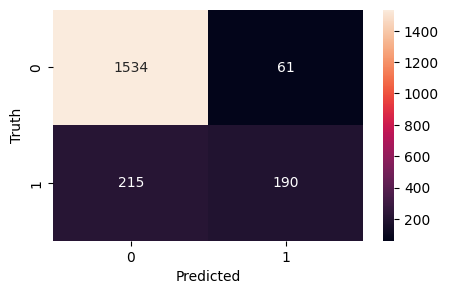

In [39]:
cm = tf.math.confusion_matrix(labels = y_test, predictions = y_predict)

plt.figure(figsize = (5, 3))
sb.heatmap(cm, annot = True, fmt = 'd')
plt.xlabel('Predicted')
plt.ylabel('Truth')

### Saving the Model

In [40]:
# Saving the entire model to a file
model.save('bank_churn_prediction_model.h5')

In [42]:
# Saving only the model weights
model.save_weights('bank_churn_prediction_model_weights.weights.h5')
